In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [22]:
posteriors_8_npEM = pd.read_csv('../../cluster_code/results/npEM_npMSL_replicates/posteriors_npEM_maxiter_100_cluster-size_8_.csv', index_col = 0)
posteriors_8_npMSL = pd.read_csv('../../cluster_code/results/npEM_npMSL_replicates/posteriors_npMSL_maxiter_2000_cluster-size_8_.csv', index_col = 0)
posteriors_9_npMSL = pd.read_csv('../../cluster_code/results/npEM_npMSL_replicates/posteriors_npMSL_maxiter_2000_cluster-size_9_.csv', index_col = 0)
posteriors_9_npEM = pd.read_csv('../../cluster_code/results/npEM_npMSL_replicates/posteriors_npEM_maxiter_100_cluster-size_9_.csv', index_col = 0)
posteriors_10_npMSL = pd.read_csv('../../cluster_code/results/npEM_npMSL_replicates/posteriors_npMSL_maxiter_2000_cluster-size_10_.csv', index_col = 0)
posteriors_10_npEM = pd.read_csv('../../cluster_code/results/npEM_npMSL_replicates/posteriors_npEM_maxiter_100_cluster-size_10_.csv', index_col = 0)

In [23]:
data_points = pd.read_csv('./data/1_5_CPMcutoff_suffix_1_log_cero_replacement.csv', index_col = 0)

In [24]:
names = ['npEM_8','npMSL_8','npEM_9','npMSL_9','npEM_10','npMSL_10']
datasets = [
    posteriors_8_npEM,
    posteriors_8_npMSL,
    posteriors_9_npEM,
    posteriors_9_npMSL,
    posteriors_10_npEM,
    posteriors_10_npMSL    
]

In [25]:
df = pd.DataFrame({})
for name, data in zip (names,datasets):
    df[name] = np.argmax(data.values, axis = 1)
df.index = data_points.index
df.head()

,npEM_8,npMSL_8,npEM_9,npMSL_9,npEM_10,npMSL_10
gene,,,,,,
ENSG00000000003,4,1,5,0,6,0
ENSG00000000419,4,1,5,0,6,4
ENSG00000000457,6,2,3,5,1,7
ENSG00000000460,6,6,7,8,2,3
ENSG00000001036,4,1,5,0,6,4


In [26]:
df.to_csv('./results/np_labels/grouped_labels_repeated_measures.csv')

In [27]:
for col in df.columns:
    df[[col]].to_csv('./results/np_labels/labels_{}_repeated_measures.csv'.format(col))

In [28]:
df.astype(str).describe(include='all')

,npEM_8,npMSL_8,npEM_9,npMSL_9,npEM_10,npMSL_10
count,16247,16247,16247,16247,16247,16247
unique,8,8,9,9,10,10
top,4,6,7,8,6,0
freq,3269,3494,3313,3487,2774,3059


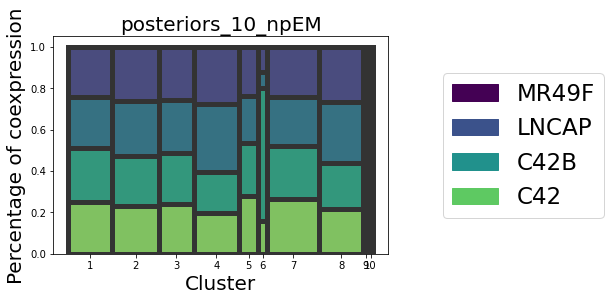

In [29]:
def change_width(ax, new_value) :
    cnt = 0
    for patch in ax.patches :
        current_width = patch.get_width()
        patch.set_width(new_value[cnt] * len(new_value))
        patch.set_x((np.cumsum(new_value)[cnt]-new_value[cnt])*len(new_value))
        cnt = (cnt+1) % len(new_value)
            
def lambda_plotting(data_points, posteriors = None, labels = None,ax = None):    
    if posteriors is None and labels is None :
        raise Exception('posteriors and labels can\'t be both None!') 
    if ax is None :
        raise Exception('ax can not be null')
    if labels is None :
        labels = pd.DataFrame(pd.Series(np.argmax(posteriors.values, axis=1)))
    
    
    data_points_percentage = data_points.copy()
    data_points_percentage['label'] = labels.values
    data_percentages = data_points_percentage.groupby('label').sum()

    for col in data_percentages:
        data_percentages[col] = data_percentages[col] / np.sum(data_percentages[col])
    sum_hor = np.sum(data_percentages, axis = 1)
    for col in data_percentages:
        data_percentages[col] = data_percentages[col] / sum_hor
    
    data_percentages.iloc[:,:] = np.cumsum(data_percentages.values, axis = 1)
    
    
    val,ori,label = [],[],[]
    for col in data_percentages:
        val.extend(data_percentages[col].values)
        ori.extend([col]*len(data_percentages))
        label.extend(list(range(1,len(data_percentages)+1)))
    df = pd.DataFrame({'value':val,'origin':ori, 'label': label})
    
    
    
    
    g1 = sns.barplot(data = df, 
                y = 'value', 
                x = 'label', 
                hue = 'origin', 
                dodge = False, 
                hue_order = data_percentages.columns[::-1], 
                palette = 'viridis',
                ax = ax,
               );
    g2 = sns.barplot(data = df, 
                y = 'value', 
                x = 'label', 
                hue = 'origin', 
                dodge = False, 
                hue_order = data_percentages.columns[::-1], 
                palette = 'viridis',
                ax = ax,
                linewidth= 5.0,
                facecolor=(1,1,1,0),
                edgecolor=".2"
               );
    
    
    widths = labels.value_counts(normalize = True).sort_index().values
    widths_offset = np.zeros(widths.shape)
    widths_offset[:-1] = widths[1:]
    change_width(ax = ax, new_value = widths)
    ax.set_xticks(((np.cumsum(widths)-widths)+(np.cumsum(widths_offset)-widths_offset))*len(widths)/ 2.0 + (widths[0])*len(widths)/2.0)
    ax.set_xticklabels(list(range(1,len(widths)+1)),fontsize=10)
    ax.set_xlabel('Cluster', fontsize=20)
    ax.set_ylabel('Percentage of coexpression', fontsize=20)
    ax.set_xlim(-0.5,len(df['label'].unique())+.5)
    #plt.legend([], [], frameon=False )
    
    ax.get_legend().remove()
    #red_patch = mpatches.Patch(color='#5ec962', label='The red data')
    ax.figure.legend(handles=[
        mpatches.Patch(color='#440154', label='MR49F'),
        mpatches.Patch(color='#3b528b', label='LNCAP'),
        mpatches.Patch(color='#21918c', label='C42B'),
        mpatches.Patch(color='#5ec962', label='C42')
                             ],
                     loc='center left', 
                     bbox_to_anchor=(1.0, 0.5),
                     fontsize=23
                    )
    #plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    #plt.tight_layout()

fig, ax = plt.subplots()

lambda_plotting(data_points, posteriors=posteriors_10_npEM, ax = ax);

ax.set_title('posteriors_10_npEM', fontdict={'fontsize':20});

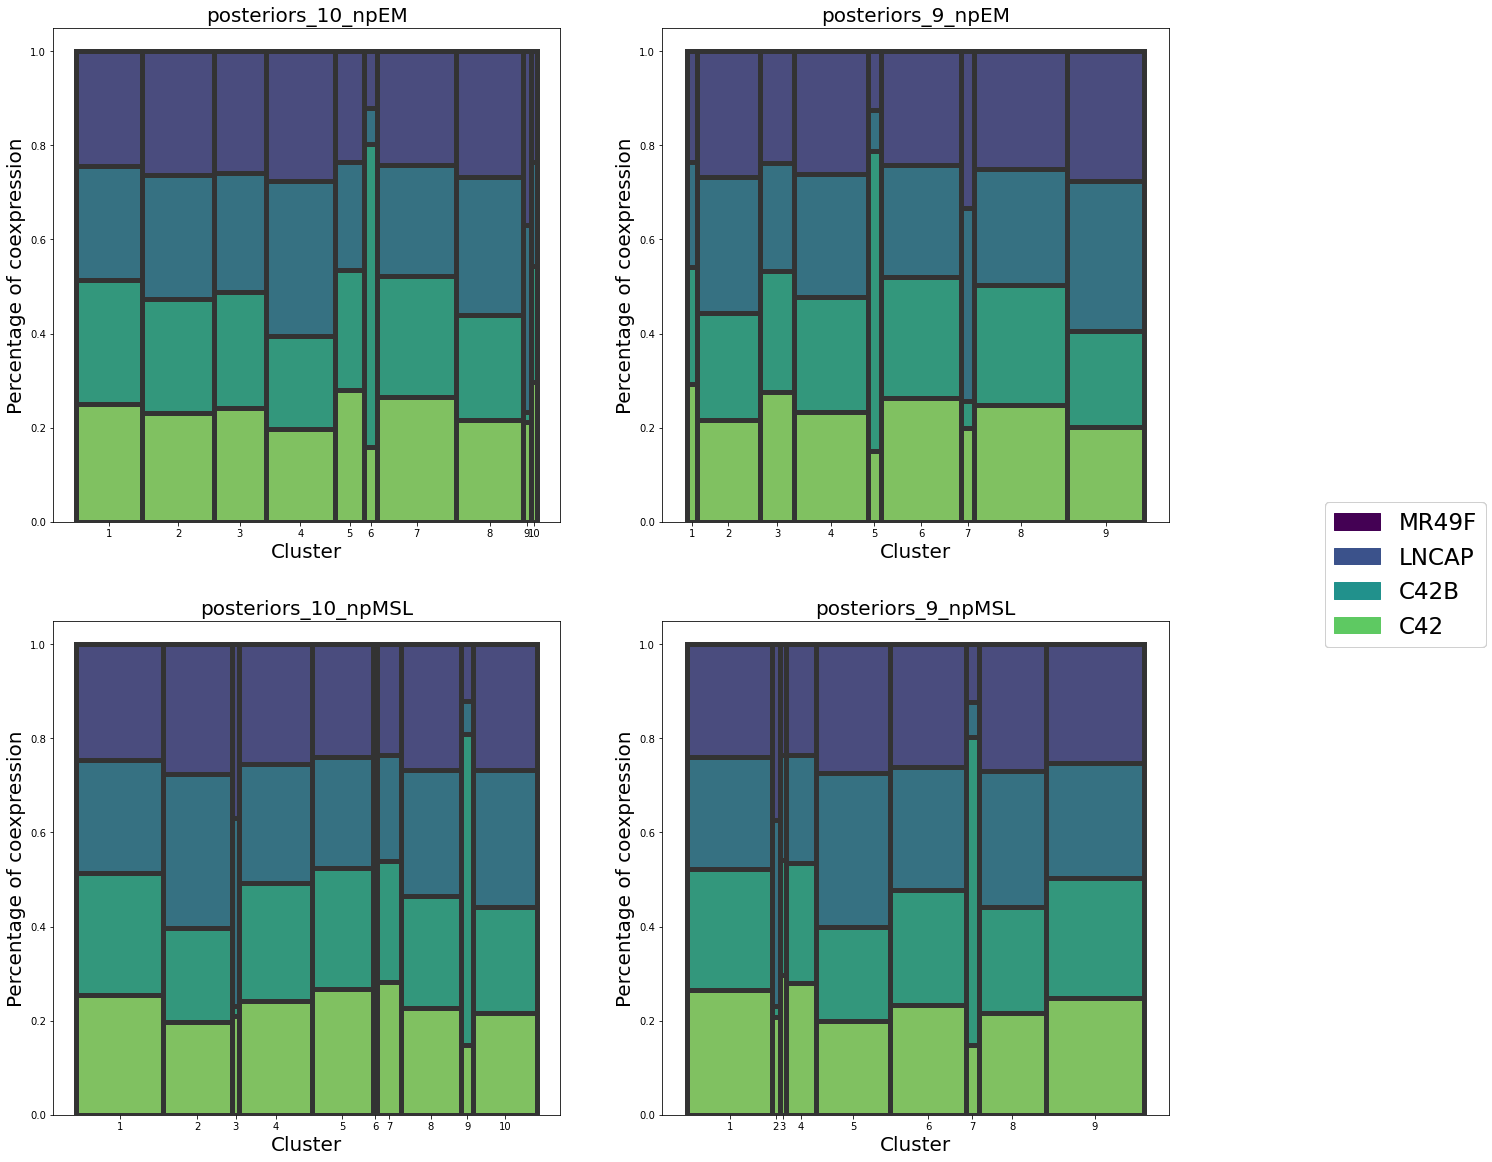

In [39]:
fig, ax = plt.subplots(ncols = 2, nrows = 2)
lambda_plotting(data_points, posteriors=posteriors_10_npEM, ax = ax[0,0]);
ax[0,0].set_title('posteriors_10_npEM', fontdict={'fontsize':20})
lambda_plotting(data_points, posteriors=posteriors_9_npEM, ax = ax[0,1]);
ax[0,1].set_title('posteriors_9_npEM', fontdict={'fontsize':20})
lambda_plotting(data_points, posteriors=posteriors_10_npMSL, ax = ax[1,0]);
ax[1,0].set_title('posteriors_10_npMSL', fontdict={'fontsize':20})
lambda_plotting(data_points, posteriors=posteriors_9_npMSL, ax = ax[1,1]);
ax[1,1].set_title('posteriors_9_npMSL', fontdict={'fontsize':20})
fig.set_size_inches(20, 20)
ax[1,0].legend([], [] ,frameon=False )
ax[1,1].legend([], [] ,frameon=False )
ax[0,0].legend([], [] ,frameon=False )
ax[0,1].legend([], [] ,frameon=False )

#fig.tight_layout()
#fig.subplots_adjust(right=1.15)
fig.savefig('lambda_plots_npEM_npMSL_10_9.png', dpi=300, facecolor='white', bbox_inches = "tight")

# Calculate ARI between them

In [40]:
from sklearn.metrics.cluster import adjusted_rand_score

In [47]:
def get_labels_from_post(x):
    return np.argmax(x.values, axis = 1 )
print("ARI npEM 8 - npEM 9 :   \t",adjusted_rand_score(
    get_labels_from_post(posteriors_8_npEM),
    get_labels_from_post(posteriors_9_npEM),
))
print("ARI npEM 9 - npEM 10 :  \t",adjusted_rand_score(
    get_labels_from_post(posteriors_9_npEM),
    get_labels_from_post(posteriors_10_npEM),
))
print("ARI npEM 8 - npEM 10 :  \t",adjusted_rand_score(
    get_labels_from_post(posteriors_8_npEM),
    get_labels_from_post(posteriors_10_npEM),
))
print("ARI npMSL 8 - npMSL 9 : \t",adjusted_rand_score(
    get_labels_from_post(posteriors_9_npMSL),
    get_labels_from_post(posteriors_8_npMSL),
))
print("ARI npMSL 9 - npMSL 10 : \t",adjusted_rand_score(
    get_labels_from_post(posteriors_9_npMSL),
    get_labels_from_post(posteriors_10_npMSL),
))
print("ARI npMSL 8 - npMSL 10 : \t",adjusted_rand_score(
    get_labels_from_post(posteriors_8_npMSL),
    get_labels_from_post(posteriors_10_npMSL),
))


ARI npEM 8 - npEM 9 :   	 0.44670333808057755
ARI npEM 9 - npEM 10 :  	 0.631479779548919
ARI npEM 8 - npEM 10 :  	 0.5011538115716372
ARI npMSL 8 - npMSL 9 : 	 0.9276392858286493
ARI npMSL 9 - npMSL 10 : 	 0.5853281395700995
ARI npMSL 8 - npMSL 10 : 	 0.588501856225295
